# Assignment 2 - Image Inpainting

Name: Rebecka Fahrni 
Matriculation number: 18-735-522

In [5]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from scipy import sparse
from scipy.signal import convolve2d
import numpy as np
from hessian_matrix import *

## Test Image

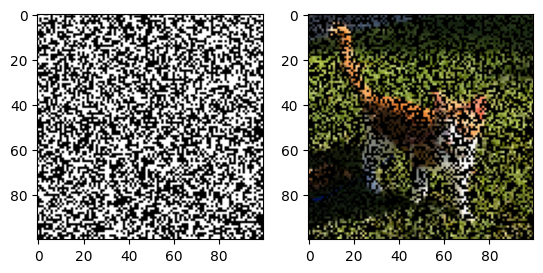

In [6]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png'))/ 255
g = masked_img

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(omega, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(g)

## hessian_matrix() function

We provide the implementation of the hessian matrix.

input variables: 
- u: your image
- omega: binary mask
- reg: regularization parameter

Example usage:

In [7]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, omega, reg_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  8. -2.  0. -2.  0.  0.  0.  0.]
 [ 0. -2.  6.  0.  0. -2.  0.  0.  0.]
 [-2.  0.  0.  8. -2.  0. -2.  0.  0.]
 [ 0. -2.  0. -2. 10. -2.  0. -2.  0.]
 [ 0.  0. -2.  0. -2.  8.  0.  0. -2.]
 [ 0.  0.  0. -2.  0.  0.  6. -2.  0.]
 [ 0.  0.  0.  0. -2.  0. -2.  6. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  6.]]


## Implementation


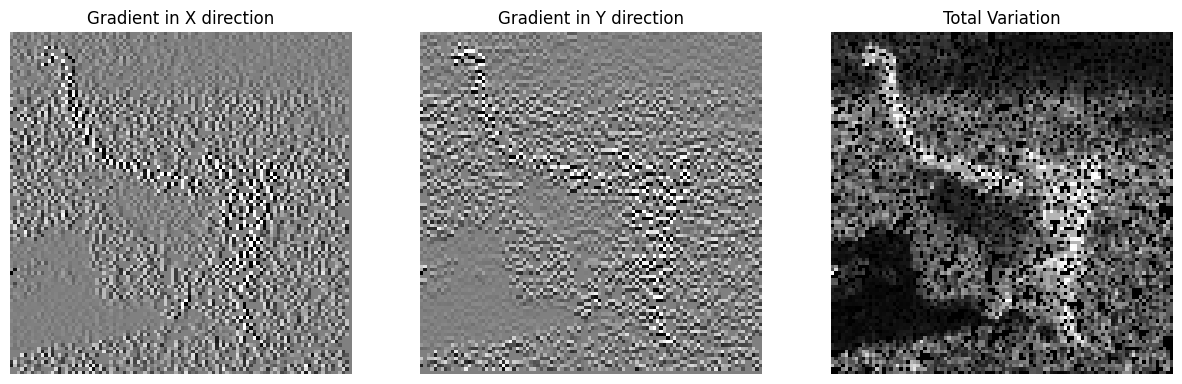

In [9]:
def finite_difference_gradients(image):
    """
    Calculate the finite difference gradients for the image.
    
    Args:
    image (numpy.ndarray): The input image for which to calculate the gradients.
    
    Returns:
    numpy.ndarray: The gradient approximation of the image.
    """
    # Initialize gradient approximations to zero
    grad_x = np.zeros(image.shape)
    grad_y = np.zeros(image.shape)
    
    # Calculate gradients for interior pixels
    grad_x[:, :-1] = image[:, 1:] - image[:, :-1]
    grad_y[:-1, :] = image[1:, :] - image[:-1, :]
    
    # Calculate the total variation (TV) as the L1 norm of the gradient
    tv = np.sqrt(grad_x**2 + grad_y**2)
    
    return grad_x, grad_y, tv

# Now let's compute the gradients and total variation for the provided images.
# We'll demonstrate this on a single color channel of the masked image.
# Normally, this should be done for each color channel separately.
channel_index = 0  # Let's do this for the first color channel as an example.

# Compute the finite difference gradients and total variation
grad_x, grad_y, tv = finite_difference_gradients(masked_img[:, :, channel_index])

# Visualize the gradients and total variation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient in X direction')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient in Y direction')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tv, cmap='gray')
plt.title('Total Variation')
plt.axis('off')

plt.show()


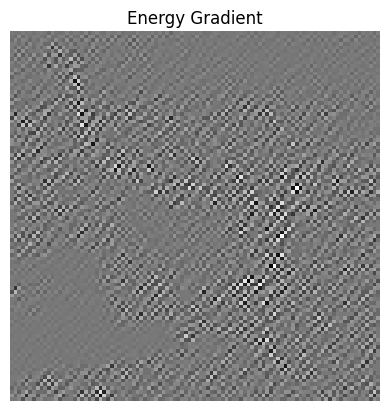

In [11]:
def compute_divergence(grad_x, grad_y):
    """
    Compute the divergence of a vector field (grad_x, grad_y).
    
    Args:
    grad_x (numpy.ndarray): The x component of the vector field.
    grad_y (numpy.ndarray): The y component of the vector field.
    
    Returns:
    numpy.ndarray: The divergence of the vector field.
    """
    # Initialize divergence to zero
    div = np.zeros_like(grad_x)
    
    # Compute the divergence using backward differences
    div[1:, :] += grad_x[1:, :] - grad_x[:-1, :]  # Difference in x direction
    div[:, 1:] += grad_y[:, 1:] - grad_y[:, :-1]  # Difference in y direction
    
    return div

def compute_energy_gradient(u, g, omega, lambda_reg):
    """
    Compute the gradient of the energy function for image inpainting.
    
    Args:
    u (numpy.ndarray): The current estimate of the inpainted image.
    g (numpy.ndarray): The original masked image.
    omega (numpy.ndarray): The mask indicating known pixel locations.
    lambda_reg (float): The regularization parameter.
    
    Returns:
    numpy.ndarray: The gradient of the energy function.
    """
    # Compute the gradient of the data term
    gradient_data = (u - g) * omega
    
    # Compute the gradient of the regularization term
    grad_u_x, grad_u_y, _ = finite_difference_gradients(u)
    div_grad_u = compute_divergence(grad_u_x, grad_u_y)
    gradient_reg = lambda_reg * div_grad_u
    
    # Combine the gradients to get the total gradient of the energy function
    total_gradient = gradient_data + gradient_reg
    
    return total_gradient

# Let's compute the energy gradient for one color channel (the first one for demonstration)
lambda_reg = 1  # Regularization parameter, to be tuned based on the problem
energy_gradient = compute_energy_gradient(masked_img[:, :, channel_index], 
                                          masked_img[:, :, channel_index], 
                                          masked_img[:, :, channel_index], 
                                          lambda_reg)

# Visualize the energy gradient
plt.imshow(energy_gradient, cmap='gray')
plt.title('Energy Gradient')
plt.axis('off')
plt.show()


In [29]:
def GD(g, omega, lmbda=0.1):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    u = g  # TODO: replace with actual implementation
    alpha = 1.0  # Step size (alpha)
    iterations = 100  # Number of iterations for the algorithm

    # Expand the dimensions of omega to match the image g
    omega_expanded = np.repeat(omega[:, :, np.newaxis], 3, axis=2)
    
    for _ in range(iterations):
        # Compute the gradient of the energy function
        grad_E = compute_energy_gradient(u, g, omega_expanded, lmbda)

        # Update 'u' by taking a step in the opposite direction of the gradient
        u -= alpha * grad_E

        # Ensure the known pixel values stay the same by resetting them to 'g'
        u = np.where(omega_expanded == 1, g, u)

        # Clip the updated 'u' to be within valid image range [0, 1]
        u = np.clip(u, 0, 1)

    return u


In [32]:
from scipy.sparse import diags, tril, triu
from scipy.sparse.linalg import spsolve

def LGS(g, omega, lmbda):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    u = g  # TODO: replace with actual implementation
    iterations = 500  # Number of iterations for the algorithm
    u_flat = u.flatten()
    g_flat = g.flatten()

    # Create the Hessian matrix
    A = hessian_matrix(u, omega, lmbda)
    
    # Split the matrix into lower and upper components
    A_lower = tril(A)
    A_upper = triu(A, k=1)

    # Create the right-hand side of the equation
    b = g_flat * (1 - omega.flatten())  # We only want to keep the known pixel values

    # Perform the Gauss-Seidel updates
    for _ in range(iterations):
        # Perform the Gauss-Seidel update
        u_flat = spsolve(A_lower, b - A_upper.dot(u_flat))

        # Enforce the boundary conditions by resetting known pixels
        u_flat[omega.flatten() == 1] = g_flat[omega.flatten() == 1]

    # Reshape 'u_flat' back to the original image shape
    u = u_flat.reshape(g.shape)

    # Clip the updated 'u' to be within valid image range [0, 1]
    u = np.clip(u, 0, 1)

    return u

## GRADIENT DESCENT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


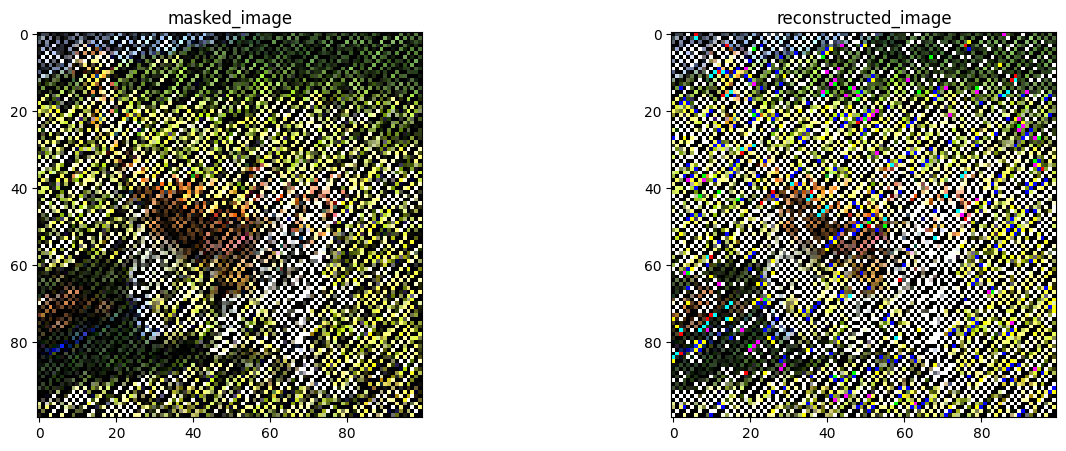

In [31]:
# run gradient descent algorithm
inpainted_img_gd = GD(g, omega, 0.1)

# for visualization purpose 
inpainted_img_gd = np.clip(inpainted_img_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_gd)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

## GAUSS - SEIDEL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


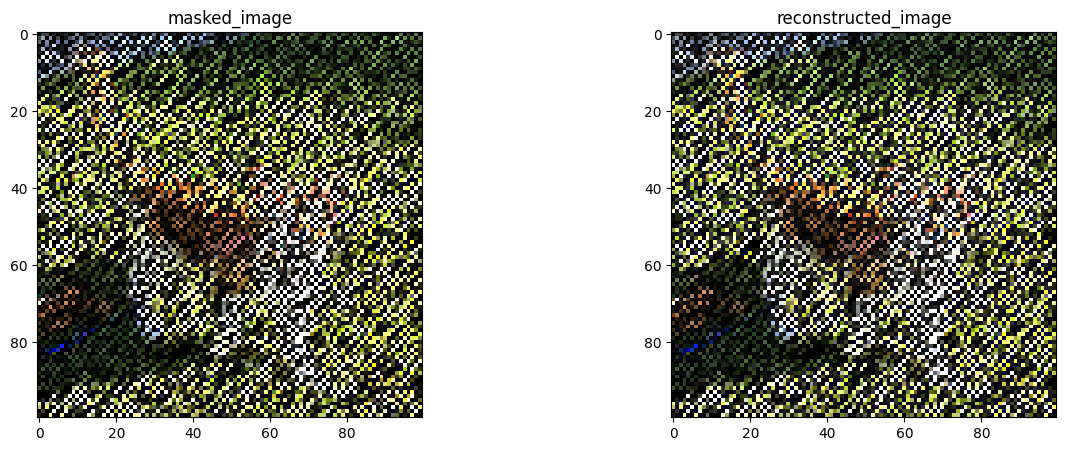

In [33]:
# run gradient descent algorithm
inpainted_img_lgs = LGS(g, omega, 0.3)

# for visualization purpose 
inpainted_img_lgs = np.clip(inpainted_img_lgs, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_lgs)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

### Effect of the regularization parameter lmbda 